In [270]:
import keras
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import imutils
import imageio
from itertools import chain
from glob import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelBinarizer                                                                                                            

In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [484]:
cur_dir = os.getcwd()
dir_captcha = os.path.join(cur_dir,"captcha_images/")
captcha_name_images = os.listdir(dir_captcha)

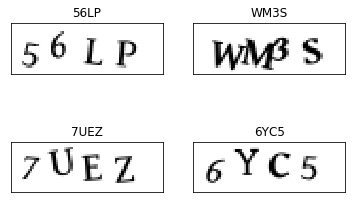

In [485]:
for i in range(4):
    random_captcha = dir_captcha + random.choice(captcha_name_images)
    captcha_image = cv2.imread(random_captcha)
    plt.subplot(2,2,i+1)
    plt.imshow(captcha_image,'gray')
    plt.title(random_captcha.split("/")[-1].split(".")[0])
    plt.xticks([]),plt.yticks([])

plt.show()

In [513]:
letters_dir = os.path.join(os.getcwd(),"letters")
if not os.path.exists(letters_dir):
    os.makedirs(letters_dir)

In [514]:
i = 0
for captcha in captcha_name_images:
    captcha_image = cv2.imread(dir_captcha + captcha)
    captcha_image_gray = cv2.cvtColor(captcha_image, cv2.COLOR_BGR2GRAY)
    captcha_image_gray = cv2.copyMakeBorder(captcha_image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    threshold = cv2.threshold(captcha_image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    im2, contours, _ = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    letter_image_regions = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))
        
    if len(letter_image_regions) != 4:
        continue
        
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    len_letter_image_regions = len(letter_image_regions)
    for letter, letter_bounding_box in zip(captcha, letter_image_regions):
        x, y, w, h = letter_bounding_box
        letter_image = captcha_image_gray[y - 2:y + h + 2, x - 2:x + w + 2]
        directory = os.path.join(letters_dir, letter)
        if not os.path.exists(directory):
            os.makedirs(directory)
        imageio.imwrite(os.path.join(directory, str(i)+'.jpg'), letter_image)
        i += 1

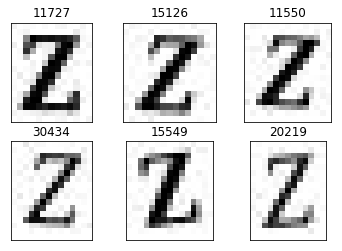

In [515]:
for i in range(6):
    letter_Z_dir = os.path.join(letters_dir, "Z")
    random_captcha = letter_Z_dir +"/"+ random.choice(os.listdir(letter_Z_dir))
    captcha_image = cv2.imread(random_captcha)
    plt.subplot(2,3,i+1)
    plt.imshow(captcha_image,'gray')
    plt.title(random_captcha.split("/")[-1].split(".")[0])
    plt.xticks([]),plt.yticks([])

plt.show()

In [286]:
X = []
y = []
for letter in os.listdir(letters_dir):
    for name in os.listdir(os.path.join(letters_dir, letter)):
        captcha_image = cv2.imread(letters_dir+ "/" + letter+ "/" + name)
        captcha = cv2.cvtColor(captcha_image, cv2.COLOR_BGR2GRAY)
        captcha = cv2.resize(captcha,(32, 32))
        captcha = np.expand_dims(captcha, axis=2)
        X.append(captcha)
        y.append(letter)
X = np.array(X, dtype="float") / 255.0                                                                                                                 
y = np.array(y) 

In [287]:
X.shape

(38775, 32, 32, 1)

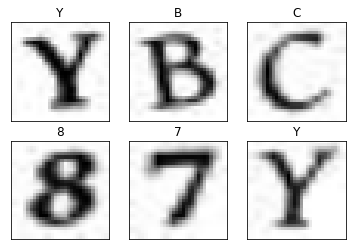

In [288]:
for i in range(6):
    index = np.random.randint(0, len(X))
    plt.subplot(2,3,i+1)
    plt.imshow(X[:,:,:,0][index],'gray')
    plt.title(y[index])
    plt.xticks([]),plt.yticks([])

plt.show()

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lb = LabelBinarizer().fit(y)                                                                                                                           
y_train_one_hot = lb.transform(y_train)                                                                                                                              
y_test_one_hot = lb.transform(y_test)

In [321]:
print("The shape of X is", X.shape)
print("The shape of X_train is", X_train.shape)
print("The shape of X_test is", X_test.shape)

The shape of X is (38775, 32, 32, 1)
The shape of X_train is (31020, 32, 32, 1)
The shape of X_test is (7755, 32, 32, 1)


In [322]:
model = Sequential()

model.add(Conv2D(6, (5, 5), padding="same", kernel_initializer=keras.initializers.glorot_normal(), input_shape=(32, 32, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(120, activation="relu"))

model.add(Dense(32, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 6)         156       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 16)        2416      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 120)               123000    
_________________________________________________________________
dense_38 (Dense)             (None, 32)                3872      
Total para

In [324]:
history = model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), batch_size=32, epochs=3)

Train on 31020 samples, validate on 7755 samples
Epoch 1/3
31020/31020 [==============================] - 84s 3ms/step - loss: 0.2823 - acc: 0.9334 - val_loss: 0.0323 - val_acc: 0.9930
Epoch 2/3
31020/31020 [==============================] - 73s 2ms/step - loss: 0.0243 - acc: 0.9942 - val_loss: 0.0147 - val_acc: 0.9959
Epoch 3/3
31020/31020 [==============================] - 87s 3ms/step - loss: 0.0094 - acc: 0.9977 - val_loss: 0.0109 - val_acc: 0.9970


In [326]:
score, acc = model.evaluate(X_test, y_test_one_hot, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

7755/7755 [==============================] - 8s 969us/step
Test score: 0.010922561660456636
Test accuracy: 0.9970341715022566


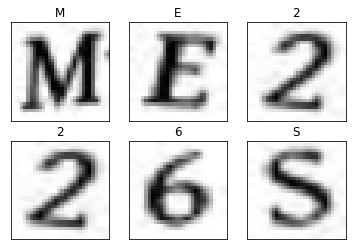

In [401]:
for i in range(6):
    index = np.random.randint(0, len(X_test))
    plt.subplot(2,3,i+1)
    test = X_test[:,:,:,0][index]
    plt.imshow(test,'gray')
    test = np.expand_dims(test, axis=2)
    value = np.argmax(model.predict([[test]]))
    plt.title(lb.classes_[value])
    plt.xticks([]),plt.yticks([])
plt.show()

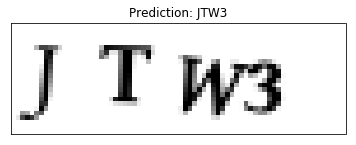

In [623]:
"""
random_captcha = dir_captcha + random.choice(captcha_name_images)
captcha_image = cv2.imread(random_captcha)
captcha_image_gray = cv2.cvtColor(captcha_image, cv2.COLOR_BGR2GRAY)
captcha_image_gray = cv2.copyMakeBorder(captcha_image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
threshold = cv2.threshold(captcha_image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
im2, contours, _ = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
letter_image_regions = []
prediction = ""
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    if w / h > 1.25:
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        letter_image_regions.append((x, y, w, h))
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
len_letter_image_regions = len(letter_image_regions)
"""

for letter, letter_bounding_box in zip(captcha, letter_image_regions):
    x, y, w, h = letter_bounding_box
    letter_image = captcha_image_gray[y - 2:y + h + 2, x - 2:x + w + 2]
    letter_image = cv2.resize(letter_image, (32, 32))
    test = np.expand_dims(letter_image, axis=2)
    value = np.argmax(model.predict([[test]]))
    prediction += lb.classes_[value]

plt.imshow(captcha_image)
plt.title("Prediction: "+ prediction)
plt.xticks([]),plt.yticks([])
plt.show()

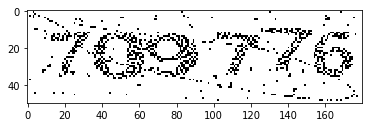

In [855]:
captcha_image = cv2.imread(random_captcha)
captcha_image_gray = cv2.cvtColor(captcha_image, cv2.COLOR_BGR2GRAY)
threshold = cv2.threshold(captcha_image_gray, 0, 255, cv2.THRESH_BINARY)[1]
plt.imshow(threshold, cmap="gray")